## Decision making
### Myriam Taisiia


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from math import sqrt, floor
import random
import sklearn
import seaborn as sns
from tqdm import tqdm
import scipy
import matplotlib as mpl


## Perceptual decision making
### 1. Generate the data

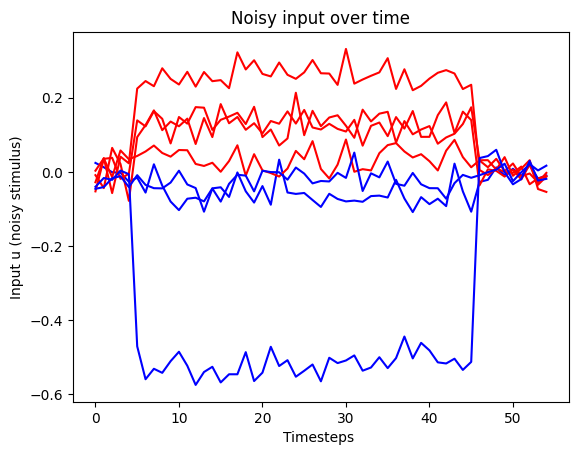

In [ ]:
def generate(t, trials, mean=0, std=0.03):
    u = np.zeros((trials, t))
    y = np.zeros((trials, t))
    for i in range(trials):
        stimulus_strength = (3.2 / 100) * np.random.choice([1, 2, 4, 8, 16]) * np.random.choice([-1, 1])

        for time in range(t):
            if 5 <= time <= 45:
                u[i][time] = stimulus_strength + np.random.normal(mean, std)
            else:
                u[i][time] = np.random.normal(mean, std)
            y[i][time] = np.sign(stimulus_strength)
    return u, y

u_test, y_test = generate (55, 7)
color = ['red' if i ==1 else 'blue' for i in y_test.T[0] ]

for i in range (7):
    plt.plot(u_test[i], c = color[i])
plt.ylabel('Input u (noisy stimulus)')
plt.xlabel('Timesteps ')
plt.title('Noisy input over time')
plt.show()

### 2. Implement the network

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt):
        super(RNN, self).__init__()
        self.dt = dt
        self.tau = 100.0  # Neuronal time constant (ms)
        self.hidden_size = hidden_size
        self.x0 = nn.Parameter(torch.randn(hidden_size), requires_grad=False)
        self.m = nn.Parameter(torch.randn(hidden_size)) # Left connectivity vector
        self.n = nn.Parameter(torch.randn(hidden_size))  # Right connectivity vector
        self.I = nn.Parameter(torch.randn(hidden_size), requires_grad=False)  # Input weights
        self.w = nn.Parameter(4*torch.randn(hidden_size), requires_grad=False)# Output weights
        self.alpha =self.dt/self.tau
        self.activation = nn.Tanh()


    def forward(self, u):
            batch_size = u.shape[0]
            seq_len = u.shape[1]
            x = self.x0
            r = self.activation(x)
            output = torch.zeros_like(u)
            r_list = []  # List to store r values for each time step
            projected_dynamics = torch.zeros(batch_size, seq_len, 2)

            for i in range(seq_len):
            #thanks to another group for help with shapes
                x = x  + self.alpha * (- x + r.matmul(self.m[:,None]).matmul(self.n[None,:]) / self.hidden_size + u[:, i, None].matmul(self.I[None,:]))
                r = self.activation(x)
                r_list.append(r)
                output[:, i] = r.matmul(self.w) /self.hidden_size

                projection = torch.cat((self.m[None,:].matmul(r.t()), self.I[None,:].matmul(r.t())), dim=0).t()
                projected_dynamics[:,i] = projection

            self.r_full = torch.stack(r_list, dim=1)

            return output,projected_dynamics



### 3. Training + 6. Projection in the (m-I) plane

In [ ]:
def train(net, _input, _target, n_epochs, lr=5e-3, batch_size=32):

    loss_mse = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    num_examples = _input.shape[0]
    all_losses = []
    input = _input
    target = _target

    for epoch in range(n_epochs):
        losses = []
        for i in range(num_examples // batch_size):
            optimizer.zero_grad()
            random_batch_idx = random.sample(range(num_examples), batch_size)
            batch = input[random_batch_idx]
            output, proj = net(batch)
            loss = loss_mse(output[:,-15:], target[random_batch_idx][:,-15:])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            loss.detach_()
            output.detach_()

        all_losses.append(np.array(losses).mean())


    output, proj = net(input)
    loss = loss_mse(output[:,-15:], target[:,-15:])
    print("final loss: %.3f" % (loss))
    plt.plot(all_losses)
    plt.title("Learning curve")
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.show()

    output,proj = net.forward(input)
    output = output.squeeze().detach().numpy()
    color_t = targets.T[0]
    color = ['red' if i ==1 else 'blue' for i in color_t ]
    for i in range (100):
        plt.plot(output[i], c = color[i])
        plt.title('Output of the network over time')
        plt.xlabel('timesteps')
        plt.ylabel('output')


    plt.show()
    proj = proj.squeeze().detach().numpy()
    color_t = targets.T[0]
    color = ['red' if i >0 else 'blue' for i in color_t ]
    for i in range(100):
        plt.scatter(proj[i,:,0], proj[i,:,1], c = color[i], s = 10)
        plt.title('Projection of the outputs on the m-I plane')
        plt.xlabel('m')
        plt.ylabel('I')

    plt.show()




In [ ]:
num_trials = 100
timesteps = 75
inputs, targets = generate(timesteps,num_trials)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)


final loss: 0.000


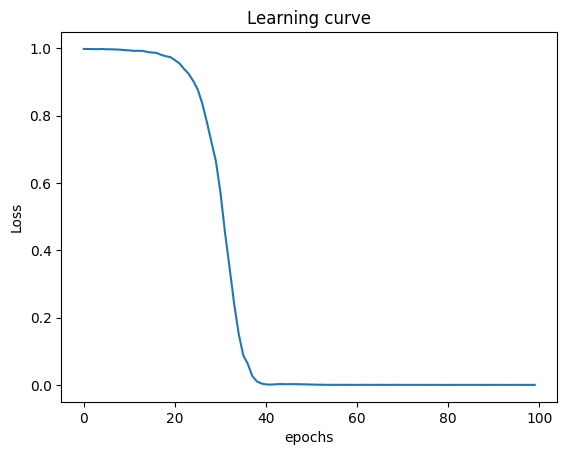

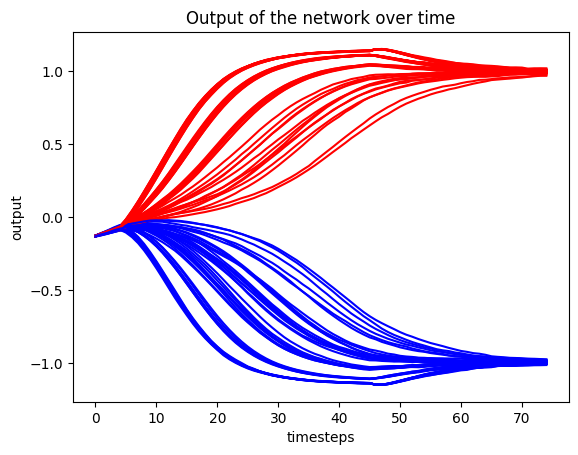

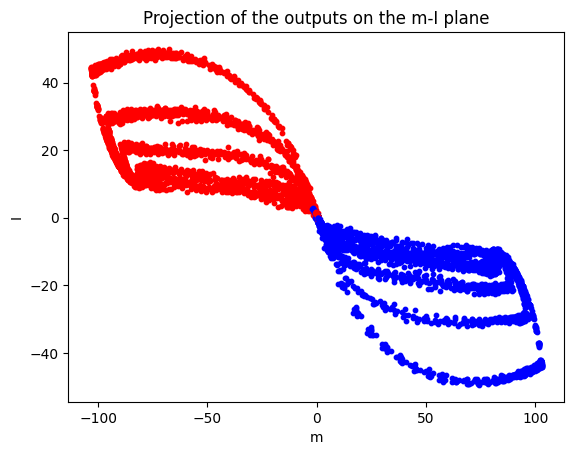

In [ ]:
net = RNN(1, 128, 1, 20)
x_train = inputs_tensor
y_train = targets_tensor
train(net, x_train, y_train, lr=5e-3, n_epochs=100, batch_size=32)

### 4. Pattern of correlations between connectivity vectors

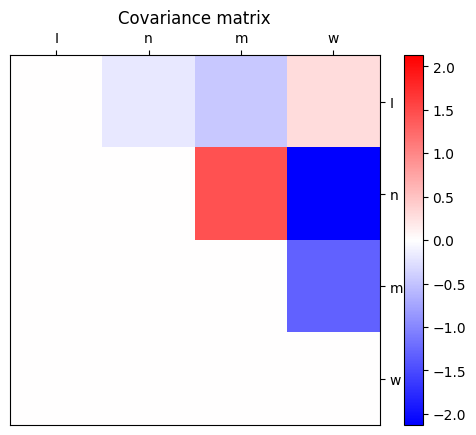

In [ ]:
n = net.n.detach().numpy().flatten()
I = net.I.detach().numpy().T.flatten()
m = net.m.detach().numpy().flatten()
w = net.w.detach().numpy().flatten()
vectors = np.array([I,n,m,w])

cm = np.cov(vectors)
cm = np.triu(cm,1)
vmin = cm.min()
vmax = cm.max()

labels = ['I', 'n','m','w']
lims = np.max((np.abs(np.min(cm)), np.abs(np.max(cm))))


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm, cmap='bwr', vmin=-lims, vmax=lims)
plt.title('Covariance matrix')
fig.colorbar(cax)
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.set_aspect('equal')

plt.xticks(np.arange(0, len(labels), step=1), labels)
plt.yticks(np.arange(0, len(labels), step=1), labels)

plt.show()

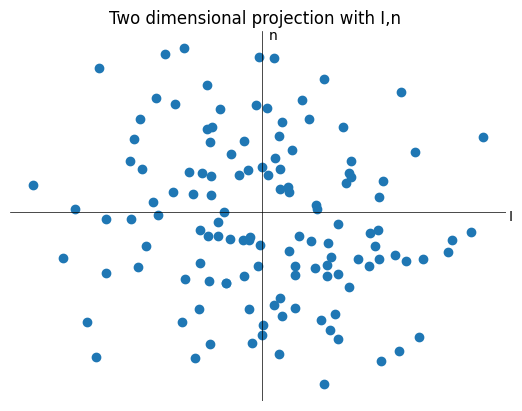

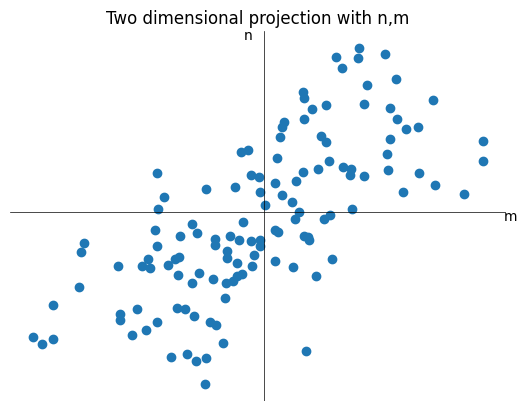

In [ ]:
plt.scatter(I,n)
plt.box(False)
plt.axis(False)
plt.title('Two dimensional projection with I,n ')
ax = plt.gca()
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'I', ha='center', va='center', transform=ax.transAxes)
ax.text(0.53, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)

plt.show()

plt.scatter(m,n)
plt.xlabel('n')
plt.ylabel('m')
plt.box(False)
plt.title('Two dimensional projection with n,m')
ax = plt.gca()
plt.axis(False)

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'm', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)

plt.xlabel('n')
plt.ylabel('m')
plt.show()


### 5. Gaussian approximation

In [ ]:
from sklearn.mixture import GaussianMixture

m_values = net.m.detach().numpy()
n_values = net.n.detach().numpy()
I_values = net.I.detach().numpy()
w_values = net.w.detach().numpy()

m_values = m_values.reshape(-1, 1)
n_values = n_values.reshape(-1, 1)
I_values = I_values.reshape(-1, 1)
w_values = w_values.reshape(-1, 1)

connectivity_vectors = np.concatenate([m_values, n_values, I_values, w_values], axis=1)
connectivity_vectors.shape

(128, 4)

In [ ]:
num_components = 1
gmm = GaussianMixture(n_components=num_components, covariance_type='full')
gmm.fit(connectivity_vectors)

GaussianMixture()

In [ ]:
num_samples = connectivity_vectors.shape[0]
resampled_data, _ = gmm.sample(num_samples)


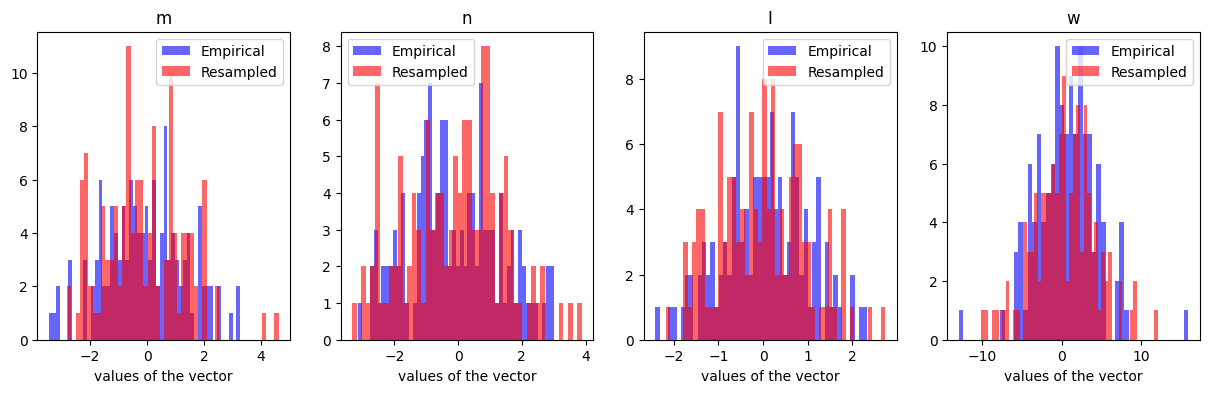

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

for i in range(4):
    axs[i].hist(connectivity_vectors[:, i], bins=50, alpha=0.6, color='blue', label='Empirical')
    axs[i].hist(np.array(resampled_data)[:, i], bins=50, alpha=0.6, color='red', label='Resampled')
    axs[i].set_xlabel('values of the vector')
    axs[i].legend()
axs[0].set_title('m')
axs[1].set_title('n')
axs[2].set_title('I')
axs[3].set_title('w')

plt.show()

Accuracy with resampled connectivity: 82.83%


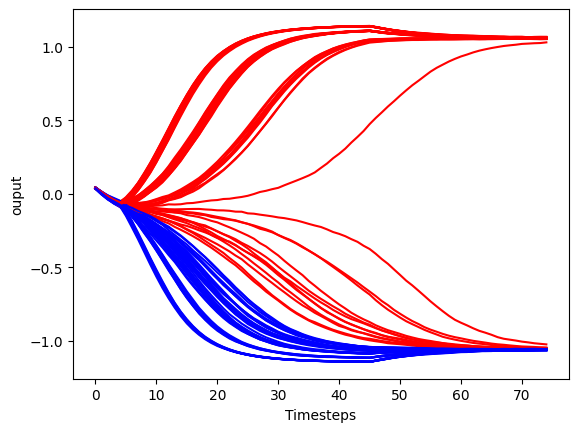

In [ ]:
resampled_data_tensor = torch.tensor(resampled_data, dtype=torch.float32)

ms = resampled_data[:,0].reshape(128)
ns = resampled_data[:,1].reshape(128)
Is = resampled_data[:,2].reshape(128)
ws = resampled_data[:,3].reshape(128)

net_new = RNN(1, 128, 1, 20)

# Update the model's parameters with the resampled data
net_new.m = nn.Parameter(torch.tensor(ms, dtype=torch.float32), requires_grad=False)
net_new.n = nn.Parameter(torch.tensor(ns, dtype=torch.float32), requires_grad=False)
net_new.I = nn.Parameter(torch.tensor(Is, dtype=torch.float32), requires_grad=False)
net_new.w = nn.Parameter(torch.tensor(ws, dtype=torch.float32), requires_grad=False)


with torch.no_grad():
    net_new.eval()
    test_output,_ = net_new(inputs_tensor)

# Compare the sign of the output with the sign of the target
output_sign = torch.sign(test_output)
target_sign = torch.sign(targets_tensor)

# Calculate accuracy
accuracy = torch.mean((output_sign == target_sign).float()).item()
print(f"Accuracy with resampled connectivity: {accuracy * 100:.2f}%")



color_t = targets.T[0]
color = ['red' if i ==1 else 'blue' for i in color_t ]
for i in range (100):
    plt.plot(test_output[i], c = color[i])
plt.xlabel('Timesteps')
plt.ylabel('ouput')
plt.show()


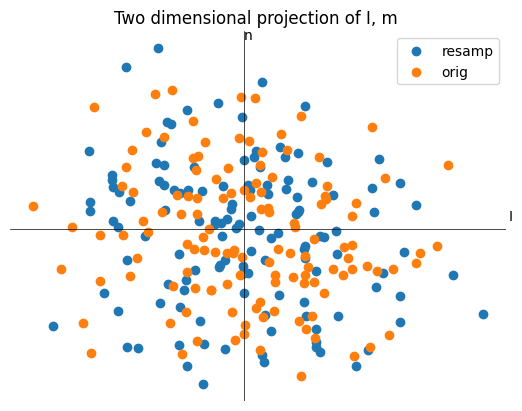

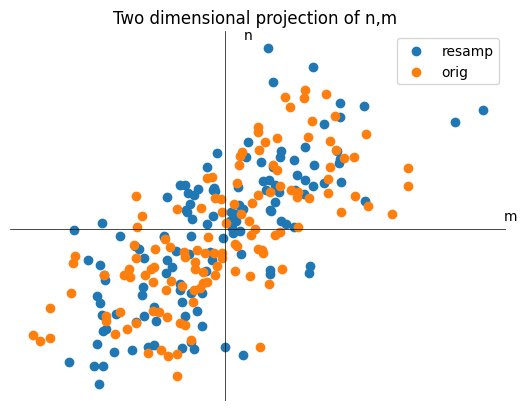

In [ ]:

plt.scatter(Is,ns, label = "resamp")
plt.scatter(I,n, label = "orig")
plt.title('Two dimensional projection of I, m ')
ax = plt.gca()
plt.axis(False)

ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'I', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)

plt.legend()
plt.show()

plt.scatter(ms,ns, label = "resamp")
plt.scatter(m,n, label = "orig")
ax = plt.gca()
plt.axis(False)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'm', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)
plt.legend()
plt.title('Two dimensional projection of n,m ')
plt.show()

# use KDE to compare

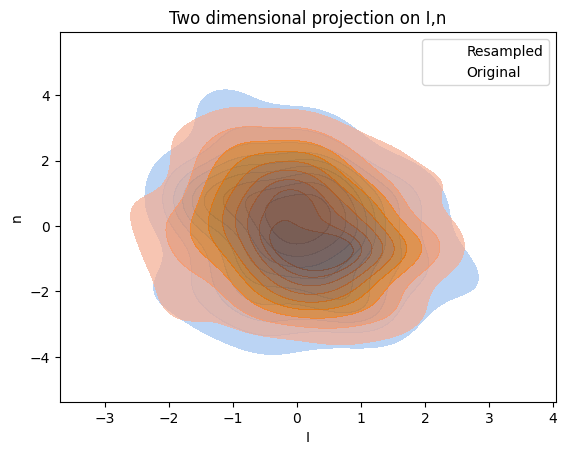

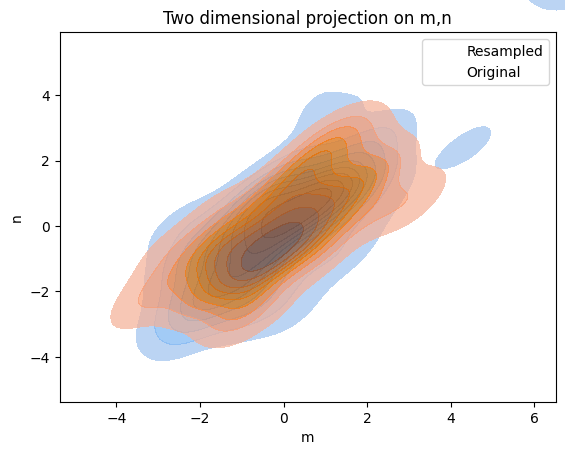

In [ ]:
sns.kdeplot(x =Is.flatten(),y=ns.flatten(), fill=True, alpha=0.7, label='Resampled')
sns.kdeplot(x=I.flatten(), y=n.flatten(), fill=True, alpha=0.7, label='Original')
plt.xlabel('I')
plt.ylabel('n')
plt.title('Two dimensional projection on I,n')
plt.legend()
plt.show()

sns.kdeplot(x =ms.flatten(),y=ns.flatten(), fill=True, alpha=0.7, label='Resampled')
sns.kdeplot(x=m.flatten(), y=n.flatten(), fill=True, alpha=0.7, label='Original')
plt.xlabel('m')
plt.ylabel('n')
plt.title('Two dimensional projection on m,n')
plt.legend()
plt.show()

### 7. One dimensional dynamical system

In [ ]:
# sigma references
sigma_mn = 1.4
sigma_nI = 2.6
sigma_mw = 2.1
sigma_w =1
sigma_n =1
sigma_I=1
sigma_m =1
sigmas= np.array([sigma_mn, sigma_nI,sigma_mw,sigma_w,sigma_n, sigma_I, sigma_m])

In [ ]:

r_values =net.r_full.detach().numpy()

r_val = r_values[0]
mn = np.concatenate([m_values, n_values], axis=1)
nI = np.concatenate([I_values, n_values], axis=1)
mw = np.concatenate([m_values, w_values], axis=1)


cov_mn = np.cov(mn.T)
cov_nI = np.cov(nI.T)
cov_mw = np.cov(mw.T)

our_sigma_mw = cov_mw[0][1]
our_sigma_w = cov_mw[1][1]
our_sigma_nI = cov_nI[0][1]
our_sigma_n = cov_nI[1][1]
our_sigma_I = cov_nI[0][0]
our_sigma_m = cov_mw[0][0]
our_sigma_mn = cov_mn[0][1]
our_sigmas= np.array([our_sigma_mn, our_sigma_nI,our_sigma_mw,our_sigma_w,our_sigma_n, our_sigma_I, our_sigma_m])

In [ ]:
from scipy.integrate import quad

def phi_prime (x):
    return (1- np.tanh(x)**2)

def dynamics(t, kappa, u, v,sigma = sigmas, tau =100.0):
    delta = np.sqrt((sigma[6]**2) * (kappa**2) + (sigma[5]**2) * u**2)
    integr = np.zeros(inputs.shape[0])
    for i in range(inputs.shape[0]):
        def phi_prime_delta_z(z):
            return (1 / (2 * np.pi)) * np.exp(-z**2 / 2) * phi_prime(delta[i] * z)
        integral, _ = quad(phi_prime_delta_z, -np.inf, np.inf)
        integr[i] = integral
    integr = integr/(1/ 2*np.pi)
    dk = (-kappa + (sigma[0]*integr) * kappa + (sigma[1] *integr)* v )* (20/tau)
    dv = (-v + u)* (20/tau)

    return dk, dv




In [ ]:
u = inputs
kappa_values = 0
v_values = 0
inter = 0
out = np.zeros((u.shape[0], u.shape[1]+1))


In [ ]:
t_span = (0, 70)
t = np.linspace(t_span[0], t_span[1], u.shape[0] + 1)
for idx in tqdm(range(u.shape[1])):
    u_in = u[:,idx]
    dk, dv = dynamics(t, kappa_values, u_in, v_values,sigma= sigmas, tau =100.0)
    kappa_values += dk
    v_values += dv
    inter = sigmas[2] * kappa_values
    out[:,idx+1] = inter



100%|██████████| 75/75 [00:07<00:00,  9.42it/s]


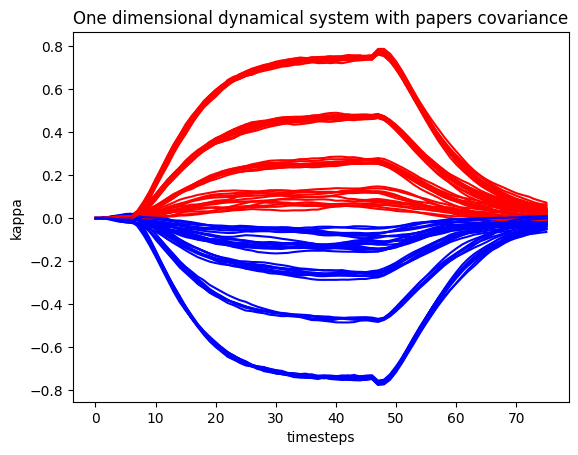

In [ ]:
color_t = targets.T[0]
color = ['red' if i ==1 else 'blue' for i in color_t ]
for i in range (100):
    plt.plot(out[i], c = color[i])
    plt.title('One dimensional dynamical system with papers covariance')
    plt.xlabel('timesteps')
    plt.ylabel('kappa')


100%|██████████| 75/75 [00:06<00:00, 11.27it/s]


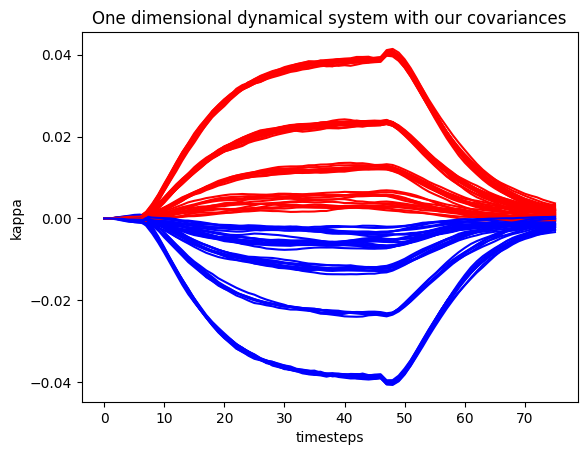

In [ ]:
kappa_values_ref = 0
v_values_ref = 0
inter_ref = 0
out_ref = np.zeros((u.shape[0], u.shape[1]+1))

for idx in tqdm(range(u.shape[1])):
    u_in = u[:,idx]
    dk, dv = dynamics(t, kappa_values_ref, u_in, v_values_ref,sigma= our_sigmas, tau =100.0)
    kappa_values_ref += dk
    v_values_ref += dv
    inter_ref = our_sigmas[2] * kappa_values_ref
    out_ref[:,idx+1] = inter_ref

for i in range (100):
    plt.plot(out_ref[i], c = color[i])
    plt.title('One dimensional dynamical system with our covariances')
    plt.xlabel('timesteps')
    plt.ylabel('kappa')



###  8. Fixed points

In [ ]:
u = inputs

def dynamics_for_minimization(kappa, u, v, sigma=sigmas, tau=100.0):
    dk, _ = dynamics(0, kappa, u, v, sigma, tau)
    return np.sum(dk**2)

initial_guess = 0.0

result = scipy.optimize.minimize(dynamics_for_minimization, initial_guess, args=(u[:, 0], v_values_ref))

fixed_point_kappa = result.x[0]
print('The fixed point is ', fixed_point_kappa)

The fixed point is  -0.00037100314560004907


## Parametric working memory
### 1. Generation of data

In [ ]:
def generate_new(t, trials, mean=0, std=0.03):
    u = np.zeros((trials, t))
    y = np.zeros((trials,t))
    f = [10,14,18,22,26,30,34]
    for i in range(trials):
        f1 = np.random.choice(f)
        f2 = np.random.choice(f)
        stimulus_strength = (3.2 / 100) * np.random.choice([1, 2, 4, 8, 16]) * np.random.choice([-1, 1])

        for time in range(t):
            if 5 <= time <= 10:
                u[i][time] = 1/24*(f1 - 22)

            elif 60 <= time <= 70:
                u[i][time] = 1/24*(f2 - 22)
            else:
                u[i][time] = 0

            y[i][time]  = (f1-f2)/24

    return u, y

u_test, y_test = generate_new (75, 7)
color = ['red' if i > 0  else 'blue' for i in y_test[:,0]]


<ipython-input-114-80957309b89c>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(plott_input, x = plott_input['variable'], y=plott_input['value'], hue=plott_input['index'],


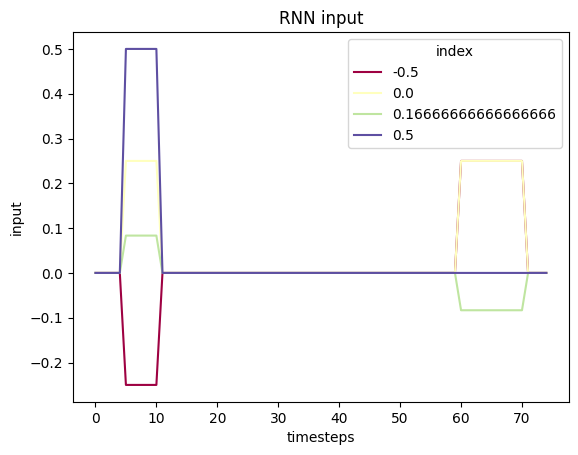

In [ ]:
plott_input  = pd.DataFrame(u_test, y_test.T[0])
plott_input.reset_index(inplace= True )
plott_input = plott_input.melt(id_vars = "index")
sns.lineplot(plott_input, x = plott_input['variable'], y=plott_input['value'], hue=plott_input['index'],
             palette="Spectral",  ci = None
            )
plt.title('RNN input')
plt.xlabel('timesteps')
plt.ylabel('input')
plt.show()

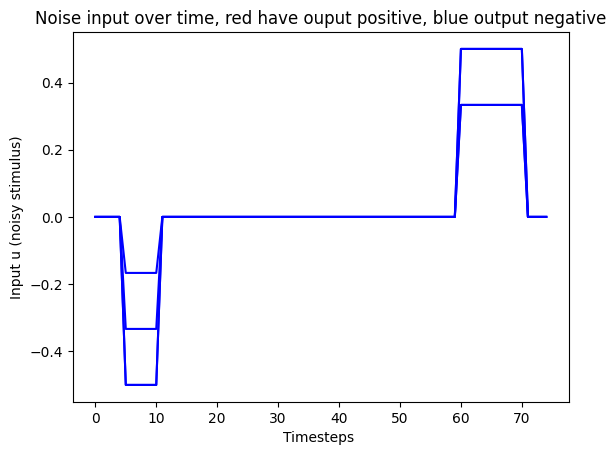

In [ ]:


for i in range (4):
    plt.plot(u_test[i], c = color[i])
plt.ylabel('Input u (noisy stimulus)')
plt.xlabel('Timesteps ')
plt.title('Noise input over time, red have ouput positive, blue output negative')
plt.show()

### 2. Create network rank 2

In [ ]:
class RNN_rank(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rank, dt):
        super(RNN_rank, self).__init__()

        self.dt = dt
        self.tau = 100.0  # Neuronal time constant (ms)
        self.hidden_size = hidden_size
        self.x0 = nn.Parameter(torch.randn(hidden_size), requires_grad=False)
        self.m = nn.Parameter(torch.randn(hidden_size, rank)) # Left connectivity vector
        self.n = nn.Parameter(torch.randn(hidden_size, rank))  # Right connectivity vector
        self.I = nn.Parameter(torch.randn(input_size,hidden_size), requires_grad=False)  # Input weights
        self.w = nn.Parameter(4*torch.randn(hidden_size, output_size), requires_grad=False)# Output weights
        self.alpha =self.dt/self.tau
        self.activation = nn.Tanh()

    def forward(self, u):
        batch_size = u.shape[0]
        seq_len = u.shape[1]
        x = self.x0
        r = self.activation(x)
        output = torch.zeros(batch_size, seq_len, 1)
        self.r_full = torch.zeros(batch_size, seq_len, self.hidden_size)

        projected_dynamics = torch.zeros(batch_size, seq_len, 2)

        for i in range(seq_len):
            r = self.activation(x)
            self.r_full[:,i,:] = r
            x = x  + self.alpha * (- x + r.matmul(self.m).matmul(self.n.t()) / self.hidden_size + u[:, i, :].matmul(self.I))
            output[:, i, :] = r.matmul(self.w) /self.hidden_size


        return output, projected_dynamics

### 3. Train network rank 2

In [ ]:
def train_rank(net, _input, _target, n_epochs, lr=5e-3, batch_size=32):

    loss_mse = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    num_examples = _input.shape[0]
    all_losses = []
    input = _input
    target = _target

    for epoch in range(n_epochs):
        losses = []
        for i in range(num_examples // batch_size):
            optimizer.zero_grad()
            random_batch_idx = random.sample(range(num_examples), batch_size)
            batch = input[random_batch_idx]
            output, proj = net(batch)
            loss = loss_mse(output[:,-5:], target[random_batch_idx][:,-5:])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            loss.detach_()
            output.detach_()
        all_losses.append(np.array(losses).mean())

    print("final loss: %.3f" % (loss.item()))
    plt.plot(all_losses)
    plt.title("Learning curve")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    output, proj = net.forward(input)

    output = output.squeeze().detach().numpy()
    plott_orig  = pd.DataFrame(output, targets.T[0])
    plott_orig.reset_index(inplace= True )
    plott_orig = plott_orig.melt(id_vars = "index")
    sns.lineplot(plott_orig, x = plott_orig['variable'], y=plott_orig['value'], hue=plott_orig['index'],
             palette="Spectral",  ci = None
            )
    plt.title('RNN output')
    plt.xlabel('timesteps')
    plt.ylabel('output')
    plt.show()

    color_t = targets.T[0]
    color = ['red' if i > 0 else 'blue' for i in color_t ]
    for i in range (100):
        plt.plot(output[i], c = color[i])
    plt.title('Output of the network over time')
    plt.xlabel('timesteps')
    plt.ylabel('output')
    plt.show()



In [ ]:
num_trials = 100
timesteps = 75
inputs, targets = generate_new(timesteps,num_trials)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)


inputs_tensor = inputs_tensor.unsqueeze(2)
targets_tensor = targets_tensor.reshape(100, 75, 1)

final loss: 0.094


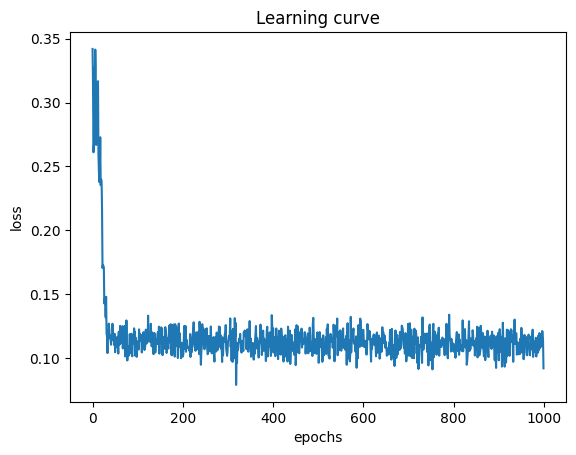

<ipython-input-28-8724a9841940>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(plott_orig, x = plott_orig['variable'], y=plott_orig['value'], hue=plott_orig['index'],


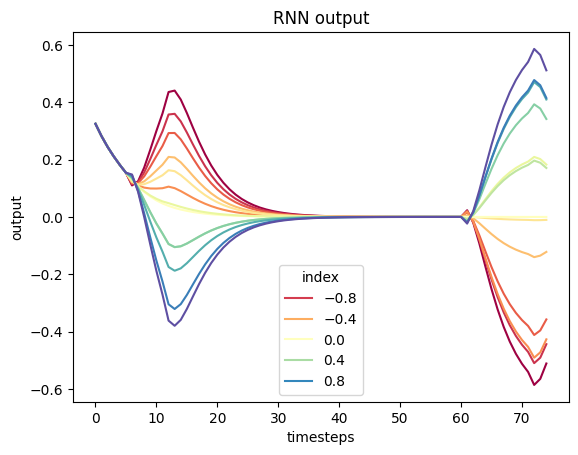

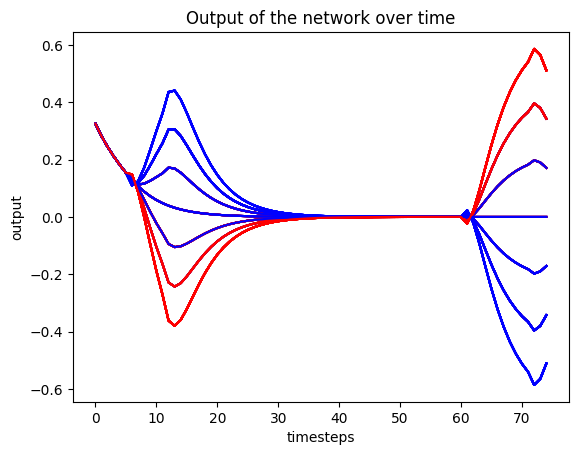

In [ ]:
net_rank = RNN_rank(1, 128, 1, 2,  20)
x_train = inputs_tensor
y_train = targets_tensor
train_rank(net_rank, x_train, y_train, lr=5e-3, n_epochs=1000, batch_size=32)

### 4. Connectivy patterns

<ipython-input-31-fd57f4ed085a>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labelstop)
<ipython-input-31-fd57f4ed085a>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labelsright)


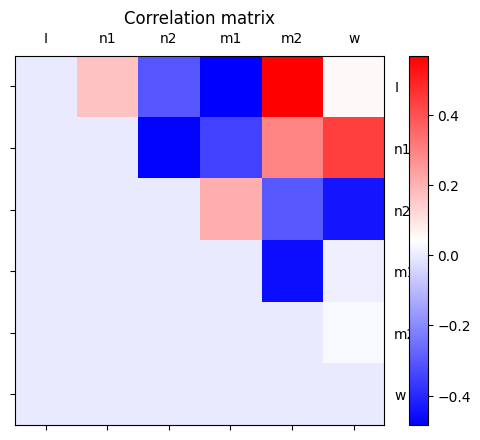

In [ ]:
n1 = net_rank.n.detach().numpy().T[0]
n2 = net_rank.n.detach().numpy().T[1]

I = net_rank.I.detach().numpy().T.flatten()
m1 = net_rank.m.detach().numpy().T[0]
m2 = net_rank.m.detach().numpy().T[1]
w = net_rank.w.detach().numpy().flatten()
vectors = [I, n1,n2,m1,m2,w]
cm = np.corrcoef(vectors)
cm = np.triu(cm,1)
vmin = cm.min()
vmax = cm.max()

labelstop = ['I','n1', 'n2','m1','m2','w']
labelsright = labelstop


fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)
cax = ax.imshow(cm,  cmap='bwr', vmin = vmin,vmax = vmax )
plt.title('Correlation matrix')
fig.colorbar(cax)
ax.tick_params(labeltop=True, labelbottom = False, labelleft =False, labelright=True)

ax.set_xticklabels([''] + labelstop)
ax.set_yticklabels([''] + labelsright)
plt.show()


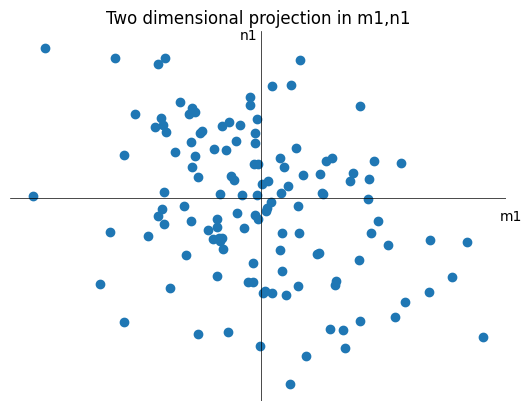

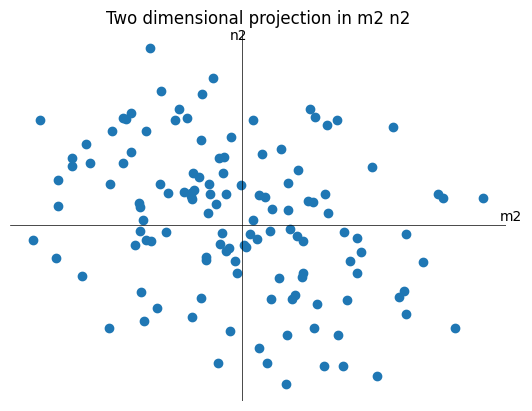

In [ ]:
plt.scatter(m1,n1)
plt.xlabel('m1')
plt.ylabel('n1')
ax = plt.gca()
plt.axis(False)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'm1', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n1', ha='center', va='center', transform=ax.transAxes)
plt.title('Two dimensional projection in m1,n1')
plt.show()


plt.scatter(m2, n2)
plt.xlabel('m2')
plt.ylabel('n2')
ax = plt.gca()
plt.axis(False)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.title('Two dimensional projection in m2 n2')
ax.text(1.01, 0.5, 'm2', ha='center', va='center', transform=ax.transAxes)
ax.text(0.46, 0.99, 'n2', ha='center', va='center', transform=ax.transAxes)
plt.show()


### 5. Projection to obtain K1,K2

In [ ]:
r_values =net_rank.r_full.detach().numpy()

r_val = r_values.mean(axis = 0)
r_val.shape

kappa1 = []
kappa2 = []
for t in range(75):
    product1 = m1.T*r_val[t]
    product2 = m2.T*r_val[t]
    summa1 = np.sum(product1)
    summa2 = np.sum(product2)
    k1 = (1/np.linalg.norm(m1.T)**2)*summa1
    k2 = (1/np.linalg.norm(m2.T)**2)*summa2
    kappa1.append(k1)
    kappa2.append(k2)


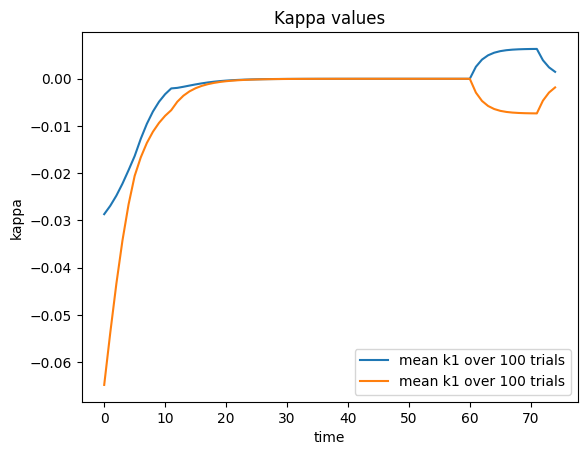

In [ ]:
plt.plot(kappa1, label = "mean k1 over 100 trials")
plt.plot(kappa2, label = "mean k1 over 100 trials")
plt.xlabel("time")
plt.ylabel("kappa")
plt.legend()
plt.title("Kappa values")
plt.show()

### 6. Fitting a Gaussian

In [ ]:
m_values_rank = net_rank.m.detach().numpy()
n_values_rank  = net_rank.n.detach().numpy()
I_values_rank  = net_rank.I.detach().numpy()
I_values_rank = I_values_rank.reshape(128,1)
w_values_rank  = net_rank.w.detach().numpy()

In [ ]:
from sklearn.mixture import GaussianMixture
connectivity_vectors_rank = np.concatenate([m_values_rank, n_values_rank,I_values_rank,w_values_rank], axis=1)
num_components = 1
gmm = GaussianMixture(n_components=num_components, covariance_type='full')
gmm.fit(connectivity_vectors_rank)

GaussianMixture()

In [ ]:
num_samples = connectivity_vectors_rank.shape[0]
resampled_data_rank, _ = gmm.sample(num_samples)

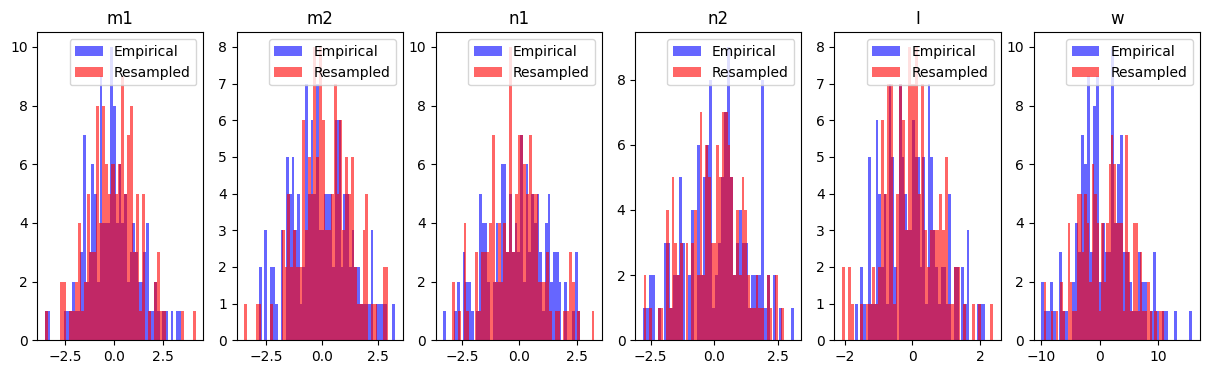

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(15, 4))

for i in range(6):
    axs[i].hist(connectivity_vectors_rank[:, i], bins=50, alpha=0.6, color='blue', label='Empirical')
    axs[i].hist(np.array(resampled_data_rank)[:, i], bins=50, alpha=0.6, color='red', label='Resampled')

    axs[i].legend()
axs[0].set_title('m1')
axs[1].set_title('m2')
axs[2].set_title('n1')
axs[3].set_title('n2')
axs[4].set_title('I')
axs[5].set_title('w')




plt.show()

In [ ]:
resampled_data_tensor_rank = torch.tensor(resampled_data_rank, dtype=torch.float32)

ms = resampled_data_rank[:,0].reshape(128,1)
ms2 = resampled_data_rank[:,1].reshape(128,1)

ns = resampled_data_rank[:,2].reshape(128,1)
ns2 = resampled_data_rank[:,3].reshape(128,1)
Is = resampled_data_rank[:,4].reshape(1,128)
ws = resampled_data_rank[:,5].reshape(128,1)

m_new = np.concatenate([ms,ms2], axis = 1)
n_new = np.concatenate([ns,ns2], axis = 1)

net_newr = RNN_rank(1, 128, 1,2, 20)

# Update the model's parameters with the resampled data
net_newr.m = nn.Parameter(torch.tensor(m_new, dtype=torch.float32), requires_grad=False)
net_newr.n = nn.Parameter(torch.tensor(n_new, dtype=torch.float32), requires_grad=False)
net_newr.I = nn.Parameter(torch.tensor(Is, dtype=torch.float32), requires_grad=False)
net_newr.w = nn.Parameter(torch.tensor(ws, dtype=torch.float32), requires_grad=False)


with torch.no_grad():
    net_newr.eval()
    test_output,_ = net_newr(inputs_tensor)

# Compare the sign of the output with the sign of the target
output_sign = torch.sign(test_output)
target_sign = torch.sign(targets_tensor)
loss_mse = nn.MSELoss()

loss_resamp = loss_mse(test_output[:,-5:], targets_tensor[:,-5:])

# Calculate accuracy
accuracy = torch.mean((output_sign == target_sign).float()).item()

print(f"Loss with resampled connectivity: {loss_resamp}%")

Loss with resampled connectivity: 0.12083365768194199%


<ipython-input-40-4fc78bf3c096>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(plott_out, x = plott_out['variable'], y=plott_out['value'], hue=plott_out['index'],


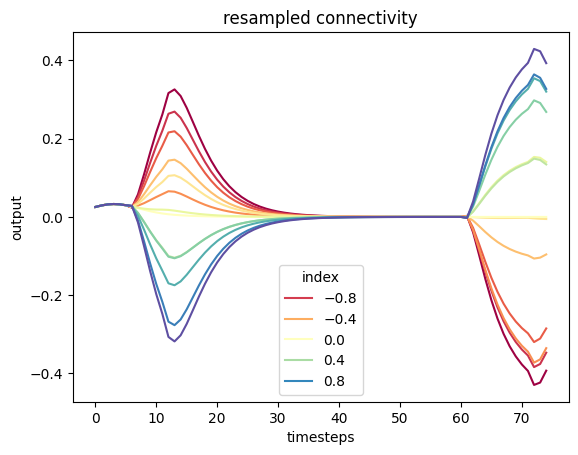

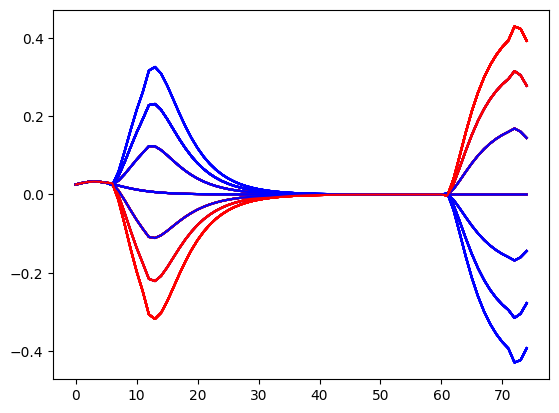

In [ ]:
import matplotlib as mpl
plott_out  = pd.DataFrame(test_output[:,:,0], targets.T[0])
plott_out.reset_index(inplace= True )
plott_out = plott_out.melt(id_vars = "index")
sns.lineplot(plott_out, x = plott_out['variable'], y=plott_out['value'], hue=plott_out['index'],
             palette="Spectral",  ci = None
            )
plt.title('resampled connectivity')
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()



color_t = targets.T[0]
color = ['red' if i > 0 else 'blue' for i in color_t ]
for i in range (100):
    plt.plot(test_output[i], c = color[i])


plt.show()

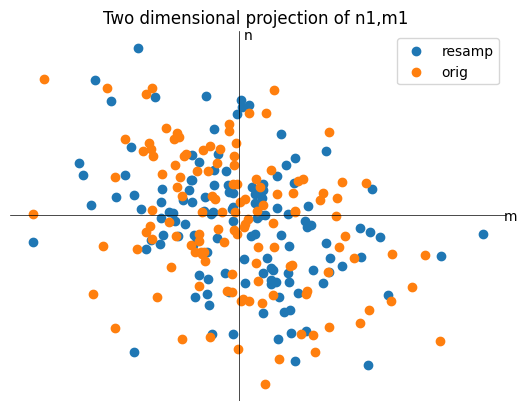

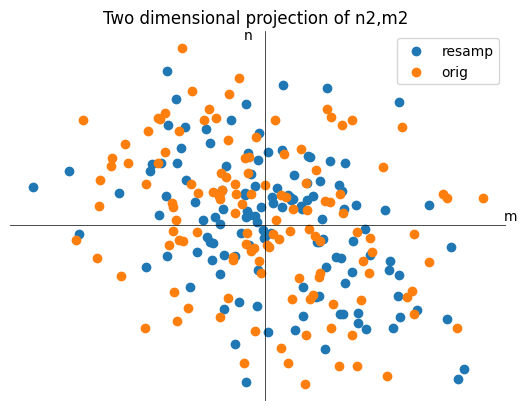

In [ ]:


plt.scatter(ms,ns, label = "resamp")
plt.scatter(m1,n1, label = "orig")
ax = plt.gca()
plt.axis(False)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'm', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)
plt.legend()
plt.title('Two dimensional projection of n1,m1 ')
plt.show()


plt.scatter(ms2,ns2, label = "resamp")
plt.scatter(m2,n2, label = "orig")
ax = plt.gca()
plt.axis(False)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.text(1.01, 0.5, 'm', ha='center', va='center', transform=ax.transAxes)
ax.text(0.48, 0.99, 'n', ha='center', va='center', transform=ax.transAxes)
plt.legend()
plt.title('Two dimensional projection of n2,m2 ')
plt.show()




# use KDE to compare

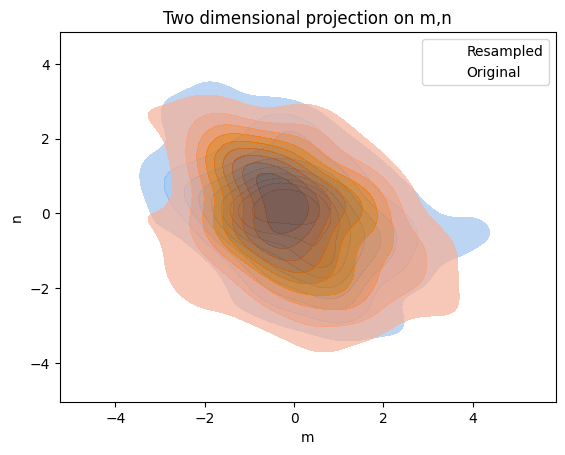

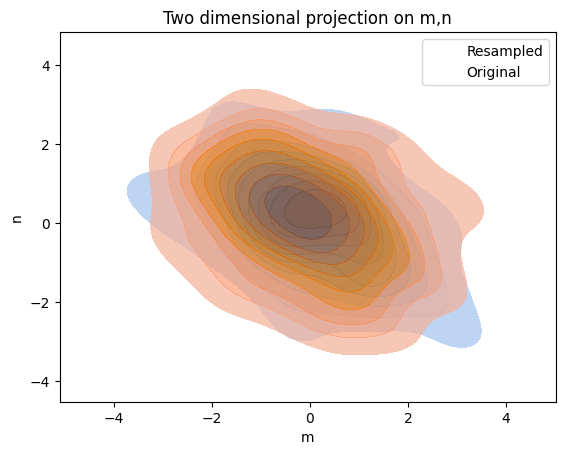

In [ ]:
sns.kdeplot(x =ms.flatten(),y=ns.flatten(), fill=True, alpha=0.7, label='Resampled')
sns.kdeplot(x=m1.flatten(), y=n1.flatten(), fill=True, alpha=0.7, label='Original')
plt.xlabel('m')
plt.ylabel('n')
plt.title('Two dimensional projection on m,n')
plt.legend()
plt.show()

sns.kdeplot(x =ms2.flatten(),y=ns2.flatten(), fill=True, alpha=0.7, label='Resampled')
sns.kdeplot(x=m2.flatten(), y=n2.flatten(), fill=True, alpha=0.7, label='Original')
plt.xlabel('m')
plt.ylabel('n')
plt.title('Two dimensional projection on m,n')
plt.legend()
plt.show()

### 7. Two dimensional equivalent circuit

In [ ]:
# reference covariances
sigma_n1m1 = 1
sigma_n2m2 = 1
sigma_n1I = 0.5
sigma_n2I = 1.9
sigma_m1w = 2.8
sigma_m2w = -2.2

In [ ]:
# our covariances
m_values_2 = net_newr.m.detach().numpy().T
n_values_2 = net_newr.n.detach().numpy().T
I_values_2 = net_newr.I.detach().numpy().T
w_values_2 = net_newr.w.detach().numpy()

n1m1 = np.concatenate([ np.reshape(n_values_2[0], (128,1)), np.reshape(m_values_2[0], (128,1))], axis=1)
n2m2 = np.concatenate([ np.reshape(n_values_2[1], (128,1)),np.reshape(m_values_2[1], (128,1))], axis=1)
n1I = np.concatenate([np.reshape(n_values_2[0], (128,1)),I_values_2], axis=1)
n2I = np.concatenate([ np.reshape(n_values_2[1],(128,1)),I_values_2], axis=1)
m1w = np.concatenate([ np.reshape(m_values_2[0],(128,1)),w_values_2], axis=1)
m2w = np.concatenate([ np.reshape(m_values_2[1],(128,1)),w_values_2], axis=1)

cov_n1m1 = np.cov(n1m1.T)
cov_n2m2 = np.cov(n2m2.T)
cov_n1I = np.cov(n1I.T)
cov_n2I = np.cov(n2I.T)
cov_m1w = np.cov(m1w.T)
cov_m2w = np.cov(m2w.T)

sigma_m1 = cov_n1m1[1][1]
sigma_m2 = cov_n2m2[1][1]
sigma_I = cov_n1I[1][1]
print(cov_n1I)
print(cov_n2I)

[[1.42968926 0.08002386]
 [0.08002386 0.66272015]]
[[ 1.33148336 -0.29703036]
 [-0.29703036  0.66272015]]


In [ ]:
def dynamics_rank2(t, kappa1,kappa2, u, v, tau = 100):
    delta = np.sqrt(sigma_m1**2 * kappa1**2 + sigma_m2**2 * kappa2**2 + sigma_I**2 * u**2)
    integr = np.zeros(inputs.shape[0])
    for i in range(inputs.shape[0]):
        def phi_prime_delta_z(z):
            return (1 / (2 * np.pi)) * np.exp(-z**2 / 2) * phi_prime(delta[i] * z)
        integral, _ = quad(phi_prime_delta_z, -np.inf, np.inf)
        integr[i] = integral

    integr = integr/(1/ 2*np.pi)
    dk1 = (-kappa1 + (sigma_n1m1*integr) * kappa1 + (sigma_n1I* integr) * v )*(20/tau)
    dk2 = (-kappa2 + (sigma_n2m2*integr) * kappa2 + (sigma_n2I* integr) * v )*(20/tau)

    dv = (-v + u)*(20/tau)

    return dk1,dk2, dv


In [ ]:
u = inputs
kappa_values1 = np.zeros(u.shape[0])
kappa_values2 = np.zeros(u.shape[0])
v_values = np.zeros(u.shape[0])
out1 = np.zeros(u.shape[0])
out_hist1 = np.zeros((u.shape[0], u.shape[1]))
out2 = np.zeros(u.shape[0])
out_hist2 = np.zeros((u.shape[0], u.shape[1]))

In [ ]:
t_span = (0, 700)
t = np.linspace(t_span[0], t_span[1], u.shape[1])
for idx in range(u.shape[1]):
    u_in = u[:,idx]
    dk1,dk2, dv = dynamics_rank2(t, kappa_values1,kappa_values2, u_in, v_values, tau =100)
    kappa_values1 +=dk1
    kappa_values2 +=dk1
    v_values += dv
    out1 = kappa_values1
    out_hist1[:,idx] = out1
    out2 = kappa_values2
    out_hist2[:,idx] = out2


In [ ]:
plott  = pd.DataFrame(out_hist1, targets.T[0])
plott.reset_index(inplace= True )
plott = plott.melt(id_vars = "index")

plott2  = pd.DataFrame(out_hist2, targets.T[0])
plott2.reset_index(inplace= True )
plott2 = plott2.melt(id_vars = "index")


<ipython-input-49-d9ef1a7db65c>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(plott, x = plott['variable'], y=plott['value'], hue=plott['index'],


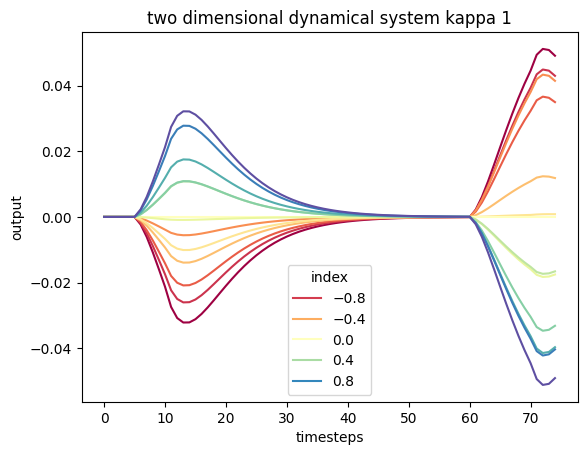

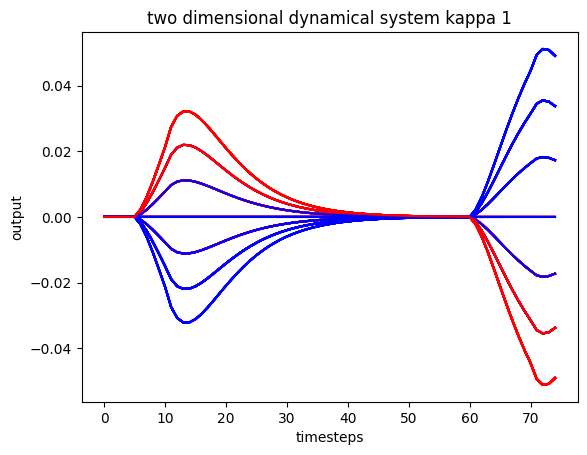

In [ ]:
sns.lineplot(plott, x = plott['variable'], y=plott['value'], hue=plott['index'],
             palette="Spectral",  ci = None
            )
plt.title('two dimensional dynamical system kappa 1')
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

for i in range(100):

    plt.plot(out_hist1[i], c = color[i])
    plt.title('two dimensional dynamical system kappa 1')
    plt.xlabel('timesteps')
    plt.ylabel('output')


<ipython-input-50-59fff235e1aa>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(plott2, x = plott2['variable'], y=plott2['value'], hue=plott2['index'],


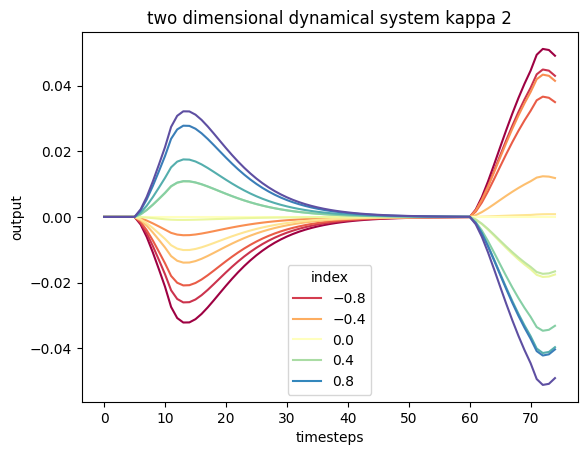

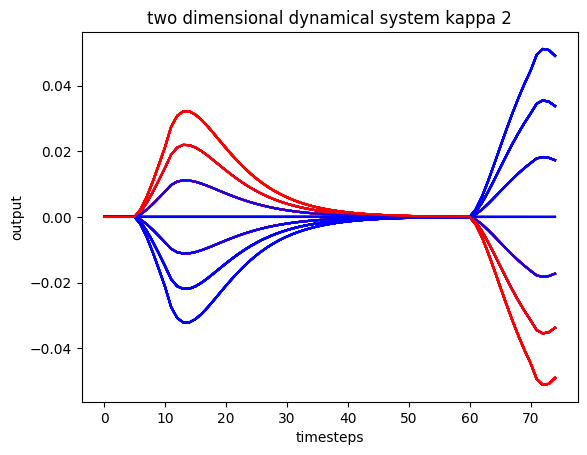

In [ ]:
sns.lineplot(plott2, x = plott2['variable'], y=plott2['value'], hue=plott2['index'],
            palette="Spectral", ci = None
            )
plt.title('two dimensional dynamical system kappa 2')
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()


for i in range(100):
    plt.plot(out_hist2[i], c = color[i])
    plt.title('two dimensional dynamical system kappa 2')
    plt.xlabel('timesteps')
    plt.ylabel('output')